# Wind-driven upwelling - 2 layer SWE analysis

***

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import gsw
import yaml
from datetime import datetime, timedelta
from cmocean import cm
from tqdm import tqdm_notebook as tqdm
from dynmodes import dynmodes
from salishsea_tools import viz_tools
from scipy import signal
from scipy.interpolate import griddata
from warnings import simplefilter
from copy import copy

%matplotlib inline
simplefilter('ignore')

In [2]:
plt.rcParams['font.size'] = 14

***

### Local functions

In [3]:
def scaling_diagram():
    """Plot scaling diagram
    """
    
    x = np.arange(0, 1.01, 0.01)
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.xaxis.set_ticks([0, 0.1, 0.2, 1])
    ax.yaxis.set_ticks([0, 0.7, 0.95, 1])
    ax.xaxis.set_ticklabels([0, '$x_u$', '$R$', '$L$'])
    ax.yaxis.set_ticklabels(['$H$', '$\delta_{Ek}$', '$z_u$', 0])
    ax.plot([0.0, 1.0], [0.7, 0.7], 'k-')
    ax.plot(x, 0.25 * np.exp(-x / 0.2) + 0.7, 'k--')
    ax.plot(x, 0.3 * np.exp((0.1-x) / 0.2) + 0.7, 'k--')
    ax.text(0.5, 0.89, '$\\frac{\\tau}{\\rho_0f}$', size=18)
    ax.arrow(0.46, 0.95, 0.1, 0, head_width=0.02, color='k')


def calc_rho(data, depth, tmask):
    """Calculate the density, rho
    """
    
    rho = gsw.rho(*[np.ma.masked_where(tmask == 0, data[k]) for k in tracers], depth)
    
    return rho

***

### Non-dimensional parameters

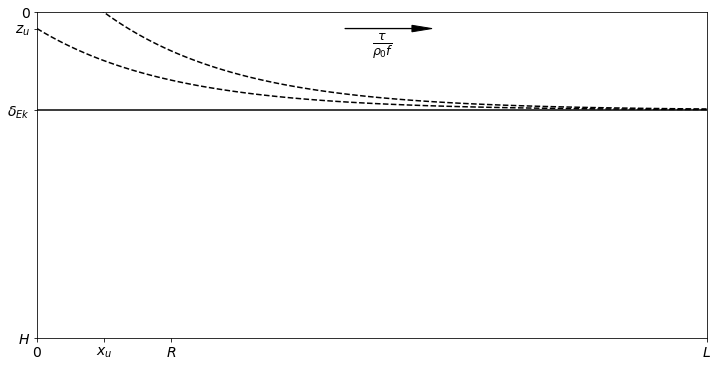

In [4]:
scaling_diagram()

Mass balance between upwelling and Ekman flux

### Pycnocline shoaling

$$\underbrace{\int_0^\infty z_ue^{-x/R}dx = z_uR}_{\text{upwelling area}} = \underbrace{\frac{1}{\rho_0f}\int_{t_0}^{t_F}\tau dt}_{\text{cumulative Ekman transport}}$$

where

$$R = \frac{NH}{f}, \hspace{1cm} N = \left(-\frac{g}{\rho_0}\frac{\partial\rho}{\partial z}\right)^{\frac{1}{2}}$$

Thus

$$\boxed{\hspace{0.5cm}\frac{z_u}{H} = \frac{1}{\rho_0NH^2}\int_{t_0}^{t_F}\tau dt\hspace{0.5cm}}$$

### Advection of the halocline front

When $z_u/z_h = 1$

$$\underbrace{\int_{x_u}^\infty z_he^{\left(x_u-x\right)/R}dx + z_hx_u = z_h\left(R + x_u\right)}_{\text{upwelling area}} = \underbrace{\frac{1}{\rho_0f}\int_{t_0}^{t_F}\tau dt}_{\text{cumulative Ekman transport}}$$

Considering again R

$$\boxed{\hspace{0.5cm}\frac{x_u}{R} = \frac{1}{\rho_0z_h^2N}\int_{t_0}^{t_F}\tau dt - 1\hspace{0.5cm}}$$

***

### NetCDF files and definitions

In [5]:
# Load subdomains and sections from YAML
with open('parameters.yaml') as f: subdomains, _, _, _ = yaml.safe_load_all(f)

bathy = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc')
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
bathy = bathy.isel(x=slice(*subdomains['ideal'][:2]), y=slice(*subdomains['ideal'][2:]))
mask = mask.isel(x=slice(*subdomains['ideal'][:2]), y=slice(*subdomains['ideal'][2:]))

# Define path and filename string
path = '/data/bmoorema/results/Lake/S4d'
fn = 'SalishSeaIdeal_1h_20170701_20170706_grid_T.nc'
depth2d = np.expand_dims(mask.gdept_1d[0, :], axis=1)
tmask = mask.tmask[0, ...]
const = {'g': 9.81, 'f': 1.11e-4, 'rho_0': 1024, 'H': 200, 'R': 5e3, 'z_h': 10, 'N': 0.01}
hour, e1t, radius, jmin, jmax, jsub = 24, 440, 2, 30, 370, 5
e3t = mask.e3t_1d[0, :].values
tracers = ['vosaline', 'votemper']

# Define scaling parameters
param = {
    'u_wind': [5, 10, 15],
    'tau': [0.034, 0.123, 0.280],
    'z_h': [10, 15, 20],
    'rho_surf': [1016, 1018, 1020],
}

# Build storage dict
runs = {}
for z_h in param['z_h']:
    runs[z_h] = {}
    for rho_s in param['rho_surf']:
        runs[z_h][rho_s] = {}
        for U in param['u_wind']:
            runs[z_h][rho_s][U] = {}
            for key in ['z_u', 'x_u']:
                runs[z_h][rho_s][U][key] = []

***

### Define coastline indices, angles and bottom slope

In [6]:
# Make coastline indices
mask_trimmed = mask.tmask[0, ...].values
mask_trimmed[:, :130, :125] = 0
mask_trimmed[:, :50, :147] = 0
ileft = [147]
iright = [150]
width = []
for row_s, row_d in zip(mask_trimmed[0, ...], mask_trimmed[30, ...]):
    i_s = np.where(abs(np.diff(row_s)) > 0)[0]
    i_d = np.where(abs(np.diff(row_d)) > 0)[0]
    if i_d.size:
        i_s_left = i_s[i_s < i_d[0]]
        if i_s_left.size:
            ileft.append(i_s_left[-1])
            iright.append(i_s[int(np.where(i_s == i_s_left[-1])[0]) + 1])
        else:
            ileft.append(ileft[-1])
            iright.append(iright[-1])
    else:
        ileft.append(ileft[-1])
        iright.append(iright[-1])

# Process arrays
ileft = ileft[1:]
window = signal.get_window('blackman', 50)
index_smooth = signal.convolve(ileft, window / sum(window), mode='same')
slope = np.diff(index_smooth)
jindex = mask.y[jmin:jmax][::jsub].values
ileft = ileft[jmin:jmax][::jsub]
slope = slope[jmin:jmax][::jsub]

# Calculate widths
#iright = iright[1:]
#iright = iright[jmin:jmax][::jsub]
#for j, il, s in zip(jindex, ileft, slope):
#    if s > 0: line = -(jindex - j) / 0 + il
#    else: line = -(jindex - j) / s + il
#    idx = np.argwhere(np.diff(np.sign(line - iright))).flatten()[0]
#    width.append(np.sqrt((iright[idx] - il)**2 + (jindex[idx] - j)**2)*e1t)

# Calculate bottom slope
bottom = np.empty((0, 50))
for j, i in zip(jindex, ileft):
    bottom = np.concatenate((bottom, bathy.Bathymetry[j, i:i+50].values[np.newaxis, :]))

bottom[bottom > 200] = 200
alpha = np.nanmax(bottom, axis=1) / np.cos(np.arctan(slope)) / np.nanargmax(bottom, axis=1) / 440

***

### Process runs

In [8]:
# Loop though z_h, rho_surf and tau
for z_h in tqdm(param['z_h']):
    for rho_s in param['rho_surf']:
        
        # Calculate R
        N = np.sqrt(const['g'] / const['rho_0'] * (const['rho_0'] - rho_s) / z_h)
        runs[z_h][rho_s]['N'] = N
        R = N * z_h / const['f']
        
        # Loop through windspeed
        for U in param['u_wind']:

            # Open results record
            runID = f'SalishSeaPond_S4d{U:02d}ms_halocline{z_h:2d}m_rhosurf{rho_s:4d}'
            file = os.path.join(path, runID, fn)
            if os.path.exists(file):
                with xr.open_dataset(file) as data:
                    
                    N = np.sqrt((data.buoy_n2[0, :31, 250, 50].values * e3t[:31]).sum(axis=0) / e3t[:31].sum())
                    runs[z_h][rho_s]['N'] = N
                    R = N * const['H'] / const['f']
                    
                    # Loop through sections
                    for i, j, s in zip(ileft, jindex, slope):
                        
                        # Lengthscale
                        L = int(radius * R / abs(np.cos(np.arctan(s))) / e1t)
                        
                        # Calculate stratification parameters
                        rho_t0 = calc_rho(data.isel(time_counter=0, y=j, x=slice(i, None)), depth2d, tmask[:, j, i:])
                        rho_halo = rho_t0[abs(depth2d[:, 0] - z_h).argmin(axis=0), :L].mean()

                        # Calculate upwelling metrics
                        rho = calc_rho(data.isel(time_counter=hour, deptht=0, y=j, x=slice(i, None)), 0, tmask[0, j, i:])
                        rho_max = rho[:L].max()
                        z_u = depth2d[int(np.median(abs(rho_t0[:, :L] - rho_max).argmin(axis=0))), 0]
                        x_u = np.cos(np.arctan(s)) * (rho >= rho_halo).sum() * e1t
                        runs[z_h][rho_s][U]['z_u'].append(z_u)
                        runs[z_h][rho_s][U]['x_u'].append(x_u)

***

### Plot results

In [99]:
def plot_results():
    """
    """
    
    # Init arrays and make plot area
    x, y, zh, z_u, x_u, S, ones = np.empty(0), np.empty(0), np.empty(0), np.empty(0), np.empty(0), np.empty(0), np.ones(len(jindex))
    fig, axs = plt.subplots(1, 4, figsize=(13, 9), gridspec_kw={'width_ratios': [1, 1, 0.5, 2], 'wspace': 0.1})
    caxs = [fig.add_axes([xpos, 0.05, 0.16, 0.01]) for xpos in [0.125, 0.305]]

    # Wind integration factor
    components = np.sin(np.arctan(2) - np.arctan(slope)) * (hour - 3) * 3600
    
    # Concatenate arrays across runs
    for z_h in param['z_h']:
        for rho_s in param['rho_surf']:
            for U, t in zip(param['u_wind'], param['tau']):
                R = runs[z_h][rho_s]['N'] * z_h / const['f']
                x = np.concatenate((x, t * components / (const['rho_0'] * z_h**2 * runs[z_h][rho_s]['N'])))
                y = np.concatenate((y, jindex))
                zh = np.concatenate((zh, z_h*ones))
                z_u = np.concatenate((z_u, np.array(runs[z_h][rho_s][U]['z_u']) / z_h))
                x_u = np.concatenate((x_u, np.array(runs[z_h][rho_s][U]['x_u']) / R))
                S = np.concatenate((S, runs[z_h][rho_s]['N'] * np.sqrt(z_h / const['H']) * alpha / const['f']))
    
    # Interpolate to contour grid and plot results
    xi, yi = np.meshgrid(np.arange(0, 3.5, 0.1), np.arange(jmax))
    x1, x2 = copy(x), copy(x)
    x1[x1 > 1], x2[x2 < 1] = 1, 1
    for ax, cax, z, label in zip(axs[:2], caxs, [z_u-x1, x_u-x2+1], ['$z_u/z_h - I_{upwell}$', '$x_u/R - I_{upwell}$']):
        data = griddata((x, y), z, (xi, yi), method='linear')
        c = ax.contourf(xi, yi, data, levels=np.arange(-2, 2.1, 0.1), cmap=cm.balance, extend='both')
        ax.plot(x, y, 'ko', markersize=2)
        ax.set_xlim([0, 3.2])
        ax.set_xlabel('$I_{upwell}$')
        fig.colorbar(c, cax=cax, orientation='horizontal', label=label, ticks=[-2, -1, 0, 1, 2])

    # Plot wind angle geometry
    axs[2].plot(alpha, jindex)
    axs[2].set_xlim([0, 0.1])
    axs[2].set_xlabel('Bottom Slope')

    # Plot coastline reference
    axs[3].contourf(bathy.Bathymetry, cmap=cm.deep)
    axs[3].contourf(tmask[0, ...], levels=[-0.01, 0.01], colors='lightgray')
    axs[3].contour(tmask[0, ...], levels=[-0.01, 0.01], colors='k')
    axs[3].plot(ileft, jindex, '-', color='magenta')
    axs[3].plot(ileft+np.nanargmax(bottom, axis=1), jindex, '-', color='r')
    axs[3].set_xlim([0, 250])
    axs[3].set_xlabel('Subdomain grid X')
    viz_tools.set_aspect(axs[3])
    for ax, col in zip(axs, range(4)):
        ax.set_ylim([20, 380])
        if col > 0: ax.yaxis.set_ticklabels('')
        else: ax.set_ylabel('Subdomain grid Y')

    return fig, axs, x, zh, x_u, z_u, S

### Longshore dependence of upwelling behavior

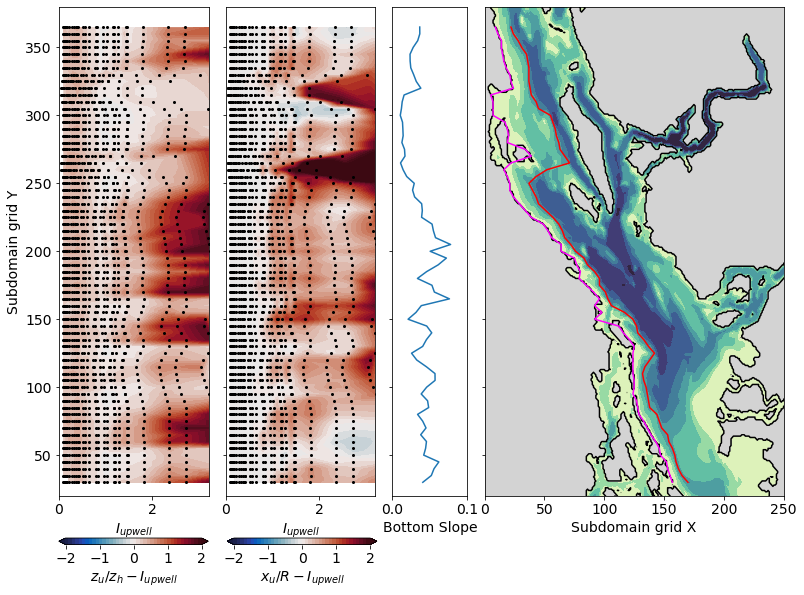

In [100]:
fig, axs, x, zh, x_u, z_u, S = plot_results()
#fig.savefig('/home/bmoorema/Desktop/ctte_meeting/slides/figures/scaling_ideal_hoffmuller.pdf', bbox_inches='tight')

### Topographic dependence (Burger number)

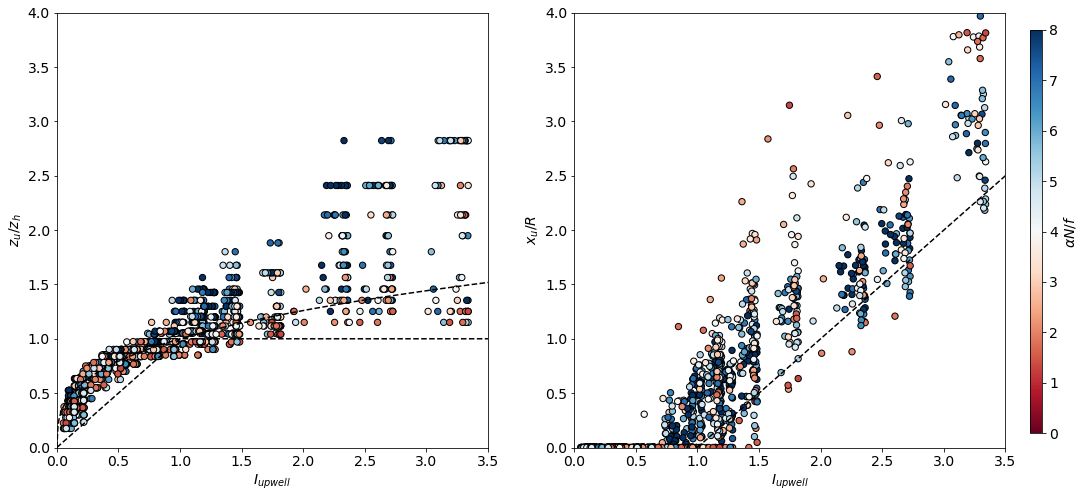

In [120]:
fig, axs = plt.subplots(1, 2, figsize=(17, 8))
cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
for ax in axs:
    ax.set_xlim([0, 3.5])
    ax.set_ylim([0, 4])
    ax.set_xlabel('$I_{upwell}$')

axs[0].plot([0, 1, 3.5], [0, 1, 1], 'k--')
axs[0].plot(np.arange(0, 3.51, 0.01), np.arange(0, 3.51, 0.01)**(1/3), 'k--')
c = axs[0].scatter(x, z_u, s=40, c=S, vmin=0, vmax=8, edgecolor='k', cmap='RdBu')
axs[0].set_ylabel('$z_u/z_h$')

axs[1].plot([1, 3.5], [0, 2.5], 'k--')
axs[1].scatter(x, x_u, s=40, c=S, vmin=0, vmax=8, edgecolor='k', cmap='RdBu')
axs[1].set_ylabel('$x_u/R$')

fig.colorbar(c, cax=cax, label='$\\alpha N/f$')

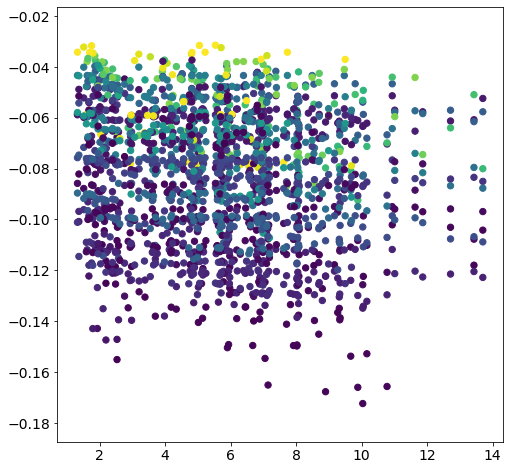

In [141]:
index = None #(x > 2) & (x < 2.5)
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(S[index], -(z_u*zh/const['H']/x**(1/2))[index], 40, x[index])

***

## Alternative models

***

### Lentz and Chapman 2004

[Lentz and Chapman 2004, JPO](https://journals.ametsoc.org/doi/full/10.1175/JPO2644.1)

Assuming:
   * geostrophic cross-shore balance
   * zero depth-integrated cross-shore velocity

the alongshore momentum balance is

$$\frac{\partial}{\partial t}\int_{-h}^0udz + \underbrace{\frac{\partial}{\partial y}\int_{-h}^0uvdz}_{\text{cross-shore momentum flux}} = -gh\frac{\partial\eta}{\partial x} + \frac{\tau_s - \tau_b}{\rho_0}$$

Assuming:
   * Thermal wind balance for $u$ profile with $u(0) = u_s$
   * Ekman flux conservation for $v$ profile
   * Constant cross-shore isopycnal slope
   * Steady State

The non-linear cross-shore advective momentum flux becomes

$$\frac{\partial}{\partial y}\int_{-h}^0uvdz \approx \frac{\tau_s}{\rho_0}\frac{bS}{1 + bS/2}$$

***

### Choboter et al. 2011

[Choboter et al. 2011, JPO](https://journals.ametsoc.org/doi/full/10.1175/2011jpo4527.1)

   * Geostrophic cross-shore balance
   * Hydrostatic
   * Conservation of mass, density and PV

The along-shore momentum balance (dimensionless)

$$\frac{\partial v}{\partial t} + u\frac{\partial v}{\partial x} + w\frac{\partial v}{\partial z} + u = -\frac{\partial p}{\partial y}$$

where

$$U = \frac{\tau}{\rho_0fH} \hspace{1cm} \text{and} \hspace{1cm} T = \frac{R}{U} = \frac{\rho_0NH^2}{\tau}$$

yields the following streamfunction equation

$$\left(1 + \frac{\partial v}{\partial x}\right)\frac{\partial^2\psi}{\partial z^2} + 2\frac{\partial\rho}{\partial x}\frac{\partial^2\psi}{\partial x\partial z} - \frac{\partial\rho}{\partial z}\frac{\partial^2\psi}{\partial x^2} = 0$$

Choboter et al. 2011 find closed form solutions

$$
\begin{align}
\psi(x, z) & = -\frac{\alpha}{\mu}\tan^{-1}\left(\coth\mu x\tan\mu z\right) \\
v(x, z, t) & = \alpha t - x -\frac{1}{2\mu}\cosh^{-1}\left(\cosh2\mu x + \frac{\sinh^22\mu x\left(e^{2\mu\alpha t} - 1\right)}{\cosh2\mu x - \cos2\mu z}\right) \\
\rho(x, z, t) & = \frac{1}{2\mu}\cos^{-1}\left(\cos2\mu z - \frac{\sin^22\mu z\left(1 - e^{-2\mu\alpha t}\right)}{\cosh2\mu x - \cos2\mu z}\right) \\
\end{align}
$$

defined over cross-shore topography

$$z_b(x) = \frac{1}{\mu}\tan^{-1}\left(\tan\mu\tanh\mu x\right)$$

where

$$S = \tan\mu = \frac{\alpha N}{f}$$

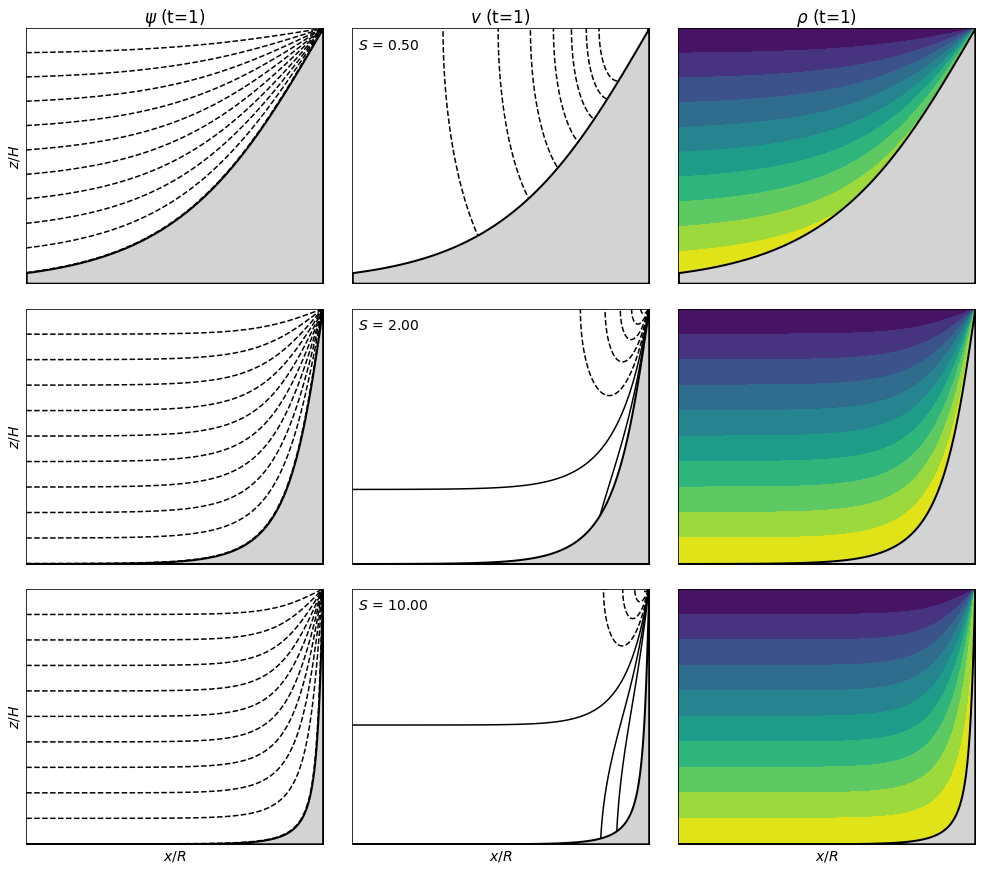

In [66]:
fig, axs = plt.subplots(3, 3, figsize=(17, 15), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})

# Define parameters
alpha = 1
t = 1
xi, zi = np.arange(-4, 0.01, 0.01), np.arange(-1, 0.01, 0.01)
x, z = np.meshgrid(xi, zi)

for row, S in zip(axs, [0.5, 2, 10]):

    # Calculate shared terms
    mu = np.arctan(S)
    denom = np.cosh(2 * mu * x) - np.cos(2 * mu * z)
    exp = 2 * mu * alpha * t

    # Calculate bathymetry
    z_b = 1 / mu * np.arctan(np.tan(mu) * np.tanh(mu * xi))

    # Calculate solutions
    psi = -alpha / mu * np.arctan(np.cosh(mu*x) / np.sinh(mu*x) * np.tan(mu*z))
    v = alpha * t - x - 1 / (2*mu) * np.arccosh(np.cosh(2*mu*x) + np.sinh(2*mu*x)**2 * (np.exp(exp) - 1) / denom)
    rho = 1 / (2*mu) * np.arccos(np.cos(2*mu*z) - np.sin(2*mu*z)**2 * (1 - np.exp(-exp)) / denom)

    # Plot solutions
    row[0].contour(x, z, psi, levels=np.arange(-1, 0, 0.1), colors='k', zorder=0)
    row[1].contour(x, z, v, levels=np.arange(-0.7, 0.3, 0.1), colors='k', zorder=0)
    row[2].contourf(x, z, rho, levels=np.arange(0, 1.1, 0.1), zorder=0)
    row[0].set_ylabel('$z/H$')
    row[1].text(0.02, 0.92, f'$S$ = {S:.2f}', transform=row[1].transAxes)
    for ax, title in zip(row, ['$\psi$ (t=1)', '$v$ (t=1)', '$\\rho$ (t=1)']):
        ax.fill_between(xi, z_b, y2=-1, facecolor='lightgray', edgecolor='k', linewidth=2, zorder=1)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        if S == 0.5: ax.set_title(title)
        elif S == 10: ax.set_xlabel('$x/R$')

***

### Depth of upwelling

Setting the density at the coast equal to the $t=0$ density at $z=Z$, and substituting $x_b = z_b/\tan\mu$

$$\rho(z_b, t) = \rho(x, Z(z_b), 0) = \frac{1}{2\mu}\cos^{-1}\left(\cos2\mu Z(z_b)\right) = -Z(z_b) = \frac{1}{2\mu}\cos^{-1}\left\{\cos2\mu z_b - \frac{\sin^22\mu z_b\left(1 - e^{-2\alpha\mu t}\right)}{\cosh\frac{2\mu z_b}{\tan\mu} - \cos2\mu z_b}\right\}$$

Taking the limit as $z_b \to 0$

$$Z = \lim_{z_b\to0}Z(z_b) = -\frac{1}{2\mu}\cos^{-1}\left\{1 - \delta\left(1 - e^{-2\alpha\mu t}\right)\right\}$$

where (using L'H&ocirc;pital's Rule)

$$\delta = \lim_{z_b\to0}\frac{\frac{\partial}{\partial z_b}\left(\sin^22\mu z_b\right)}{\frac{\partial}{\partial z_b}\left(\cosh\frac{2\mu z_b}{\tan\mu} - \cos2\mu z_b\right)} = \lim_{z_b\to0}\frac{\frac{\partial}{\partial z_b}\left(2\cos2\mu z_b\sin2\mu z_b\right)}{\frac{\partial}{\partial z_b}\left(\frac{1}{\tan\mu}\sinh\frac{2\mu z_b}{\tan\mu} + \sin2\mu z_b\right)} = \lim_{z_b\to0}\frac{2\left(\cos^22\mu z_b - \sin^22\mu z_b\right)}{\frac{1}{\tan^2\mu}\cosh\frac{2\mu z_b}{\tan\mu} + \cos2\mu z_b} = \frac{2}{\frac{1}{\tan^2\mu} + 1}$$

In dimensional terms

$$\frac{z}{H} = -\frac{1}{2\tan^{-1}(S)}\cos^{-1}\left\{1 - \frac{2S^2}{1 + S^2}\left(1 - e^{-2\alpha\tan^{-1}(S)\frac{t}{T}}\right)\right\}$$

Similarly, in order to obtain the cross-shore surface displacement

$$u(z_b) = -\frac{\alpha\sinh\frac{2\mu z_b}{\tan\mu}}{\cosh\frac{2\mu z_b}{\tan\mu} - \cos2\mu z_b}$$

$$U = \lim_{z_b\to0}u = \lim_{z_b\to0}\frac{-\alpha\frac{\partial}{\partial z_b}\left(\sinh\frac{2\mu z_b}{\tan\mu}\right)}{\frac{\partial}{\partial z_b}\left(\cosh\frac{2\mu z_b}{\tan\mu} - \cos2\mu z_b\right)} = \lim_{z_b\to0}\frac{-\alpha\frac{\partial}{\partial z_b}\left(\frac{1}{\tan\mu}\cosh\frac{2\mu z_b}{\tan\mu}\right)}{\frac{\partial}{\partial z_b}\left(\frac{1}{\tan\mu}\sinh\frac{2\mu z_b}{\tan\mu} + \sin2\mu z_b\right)} = \lim_{z_b\to0}\frac{-\frac{\alpha}{\tan^2\mu}\cosh\frac{2\mu z_b}{\tan\mu}}{\frac{1}{\tan^2\mu}\cosh\frac{2\mu z_b}{\tan\mu} + \cos2\mu z_b}$$

$$D = \frac{ut}{U} = -\frac{\alpha}{1 + \tan^2\mu}$$

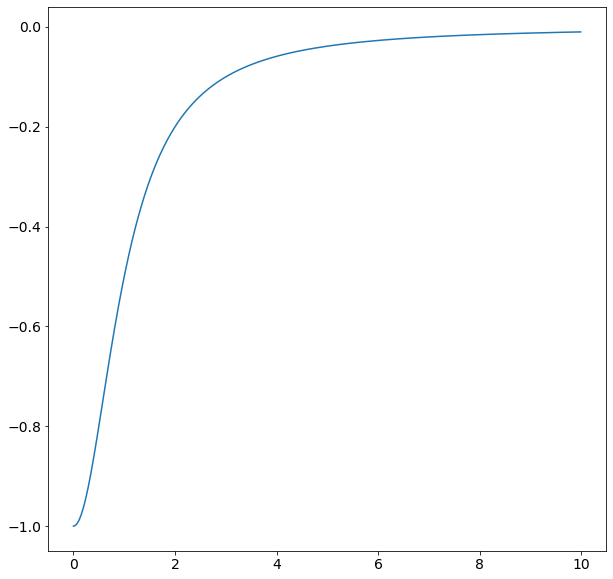

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
S = np.arange(0, 10, 0.01)
mu = np.arctan(S)

ax.plot(S, -1/(1+np.tan(mu)**2), '-')

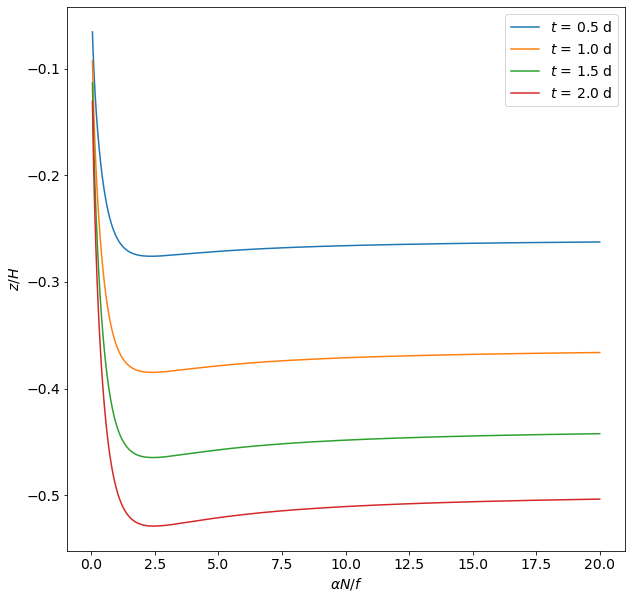

In [53]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlabel('$\\alpha N/f$')
ax.set_ylabel('$z/H$')

N = 2e-3
H = 200
rho_0 = 1e3
f = 1e-4
tau = 0.1
L = np.arange(2e2, 1e5, 10)

for t in np.arange(0.5, 2.1, 0.5):

    S = N*H/(f*L)

    exp = -2*np.arctan(S)*tau*t*86400/(rho_0*N*H**2)
    Z = -1/(2*np.arctan(S))*np.arccos(1-2*S**2/(1+S**2)*(1-np.exp(exp)))

    ax.plot(S, Z, '-', label=f'$t$ = {t:.1f} d')

    ax.legend()

***

### Lentz and Chapman 2004

[Lentz and Chapman 2004](https://journals.ametsoc.org/doi/full/10.1175/JPO2644.1)

Assuming:
   * geostrophic cross-shore balance
   * zero depth-integrated cross-shore velocity

the alongshore momentum balance is

$$\frac{\partial}{\partial t}\int_{-h}^0udz + \underbrace{\frac{\partial}{\partial y}\int_{-h}^0uvdz}_{\text{cross-shore momentum flux}} = -gh\frac{\partial\eta}{\partial x} + \frac{\tau_s - \tau_b}{\rho_0}$$

Assuming:
   * thermal wind balance for $u$ profile with $u(0) = u_s$
   * Ekman flux conservation for $v$ profile
   * Constant cross-shore isopycnal slope

the non-linear cross-shore advective momentum flux becomes

$$\frac{\partial}{\partial y}\int_{-h}^0uvdz \approx -b\frac{|\tau_s|}{\rho_0}\frac{S}{2}\left(1 + \frac{\tau_b}{\tau_s}\right)$$

To solve the time-dependent problem, assume:
   * thermal wind balance for $u$ profile with $u(-h) = u_b$
    $$u(z, t) = u_b(t) - N(z + h)$$
   * linear bottom friction
    $$\tau_b(t) = \rho_0ru_b(t)$$

Substituting into the along-axis momentum balance, the time-dependent solution for bottom Ekman layer velocity is

$$u_b(t) = \frac{\tau_s}{\rho_0r}\left(\frac{1+\frac{bS}{2}}{1-\frac{bS}{2}}\right)\left(1 - e^{-\frac{r}{h}\left(1-\frac{bS}{2}\right)t}\right)$$

***

### New steps

[Howatt and Allen 2013](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/jgrc.20401)

Now this is where I diverge from Lentz and Chapman 2004. I want to relate the time-dependent bottom velocity $u_b(t)$ to a time-dependent isopyncal displacement. Using Tara's long-axis canyon pressure gradient scaling (Howatt and Allen 2013) to scale the geostrophic cross-shore pressure gradient

$$u(z_h, t) = -\frac{1}{\rho_0f}\frac{\partial P}{\partial y} = \underbrace{-\frac{N^2Z^2}{fL} = u_b(t) - Nh}$$

Substituting in the solution for $u_b(t)$

$$\frac{Z^2}{h^2} = -\frac{1}{S}\left[\frac{\tau_s}{\rho_0rNh}\left(\frac{1+\frac{bS}{2}}{1-\frac{bS}{2}}\right)\left(1 - e^{-\frac{r}{h}\left(1-\frac{bS}{2}\right)t}\right) - 1\right]$$

Text(0, 0.5, '$Z/h$')

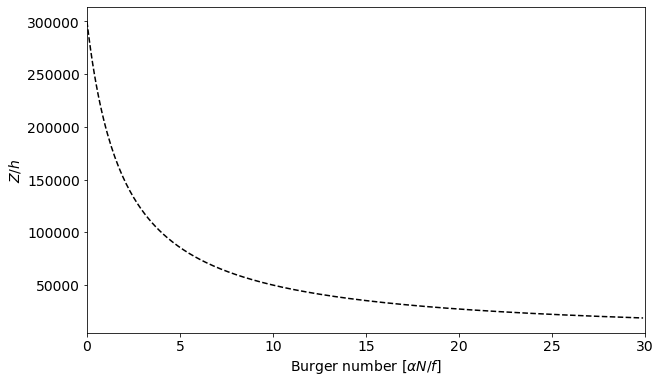

In [314]:
b = 1
t = 86400
rho_0 = 1e3
N = 1e-2
h = 300
r = 1e-3
tau = 0.1
S = np.arange(0, 30, 0.1)

Z = np.sqrt(-(tau / (rho_0 * r * N * h) * (1 + b*S/2) / (1 - b*S/2) * (1 - np.exp(-r / h * (1 - b*S/2) * t)) - 1) / S)
Z = h / r / (1 + S/2)


fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(S, Z, 'k--')
ax.set_xlim([0, 30])
#ax.set_ylim([0, 100])
ax.set_xlabel('Burger number [$\\alpha N/f$]')
ax.set_ylabel('$Z/h$')